In [63]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
import string
import warnings
plt.rcParams['text.usetex'] = False

In [2]:
# Load in only the first N rows of the ratings dataset into a pandas dataframe
N = 1000 # number of rows of data to read in
project_folder_fid = "../"
data = pd.read_csv(project_folder_fid+"matched_beer_data/ratings.csv", nrows=N)

# Display the first few rows of the dataframe
print(data.head())

# Split the dataframe into two based on columns containing 'ba' and 'rb'
ba_data = data.loc[:, data.columns.str.startswith('ba')]
rb_data = data.loc[:, data.columns.str.startswith('rb')]

# Remove the first row of useless data from each dataframe and make the new first row the column names
ba_data.columns = ba_data.iloc[0]
ba_data = ba_data[1:]
rb_data.columns = rb_data.iloc[0]
rb_data = rb_data[1:]

     ba        ba.1   ba.2     ba.3  \
0   abv  appearance  aroma  beer_id   
1  11.3         4.5    4.5      645   
2   5.0         NaN    NaN    28191   
3   5.0         3.5    3.5    57911   
4   5.0         4.0    3.5    57913   

                                            ba.4        ba.5  \
0                                      beer_name  brewery_id   
1                        Trappistes Rochefort 10         207   
2                             Myanmar Lager Beer        9369   
3  Cantillon Tyrnilambic Baie D’Argousier Lambic         388   
4              Cantillon Pikkulinnun Viskilambic         388   

                             ba.6        ba.7     ba.8    ba.9  ...  \
0                    brewery_name        date  overall  palate  ...   
1          Brasserie de Rochefort  1324810800      5.0     4.5  ...   
2  Myanmar Brewery and Distillery  1322650800      NaN     NaN  ...   
3             Brasserie Cantillon  1344074400      4.0     4.0  ...   
4             Brasserie C

In [3]:
"""
Preprocesses the input text by performing the following steps:
1. Converts the text to a string if it is not already.
2. Removes punctuation.
3. Converts all text to lowercase.
4. Tokenizes the text.
5. Removes stop words and stems the remaining words.

Parameters:
text (str): The input text to be preprocessed.

Returns:
list: A list of processed tokens after removing stop words and stemming.

TODO: Convert all spcial characters to only alphabet characters. Ask chatGPT for the regex command.
"""
def preprocess_text(text):
    
    # Convert text to string if it is not already
    text = str(text)
    
    # Remove punctuation                                                 
    text = text.translate(str.maketrans(' ', ' ', string.punctuation))

    # Convert all text to lowercase 
    text = text.lower()   

    # Tokenize the text
    tokens = word_tokenize(text)                                     
    
    # Initialize a Porter stemmer for word stemming
    stemmer = PorterStemmer()

    # Define custom stop words to remove from the text
    CUSTOM_STOP_WORDS = {"'s",'s','note','notes','almost','beer','lots','quite','maybe','lot','though', 'aroma',
                  'flavor','palate','overall','appearance',"n't",'taste','head','mouthfeel','bottle','glass',
                  'little','smell','bit','one','lot','nose','really','much','body','hint','quot','spice','itâ s',
                  'good','great', 'nice','love','like','isnt','isn','isnâ','isnâ t','isn t','don','donâ','donâ t'}
    stopwords_set = set(stopwords.words('english')).union(CUSTOM_STOP_WORDS)
    
    # Remove stop words and stem the remaining words
    # TODO: Fix stemmer. Currently, stemming changes y'to i, which is not desired.
    # tokens = [stemmer.stem(token) for token in tokens if token not in stopwords_set]
    tokens = [token for token in tokens if token not in stopwords_set]
    filtered_text = ' '.join(tokens)
    return filtered_text

In [4]:
def plot_wordcloud(text):
    text_single_string = ' '.join(text)
    # Create and generate a word cloud image
    wordcloud = WordCloud(width=800, height=400, background_color='white',colormap='viridis').generate(text_single_string)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

In [5]:
# Execute data preprocessing
warnings.filterwarnings('ignore') # Ignore useless copy warning

# 1. Remove NaN values from the data
ba_data_clean= ba_data.dropna(subset=['text'])

# 2. Apply the preprocess_text function to execute above defined text preprocessing steps
ba_data_clean.loc[:, 'preprocessed text'] = ba_data_clean.loc[:, 'text'].apply(preprocess_text)
display(ba_data_clean['text'][1])
display(ba_data_clean['preprocessed text'][1][1:10])

'Best before 27.07.2016Directly reviewed in comparison to the Westvleteren 12.The beer starts fruity with notes of dark dried plums and black cherries, not too sweet. In the middle you can notice a nice malty character with a fine but only very small bitterness and a great herbal note. No hints of the 11,3%. The dark fruity flavours develop and are still present in the end, while the sweetness and the hops keep in the background all the time.--&amp;gt; an absolutely great beer - far better than the Westvleteren 12 in direct comparison!!'

'est 27072'

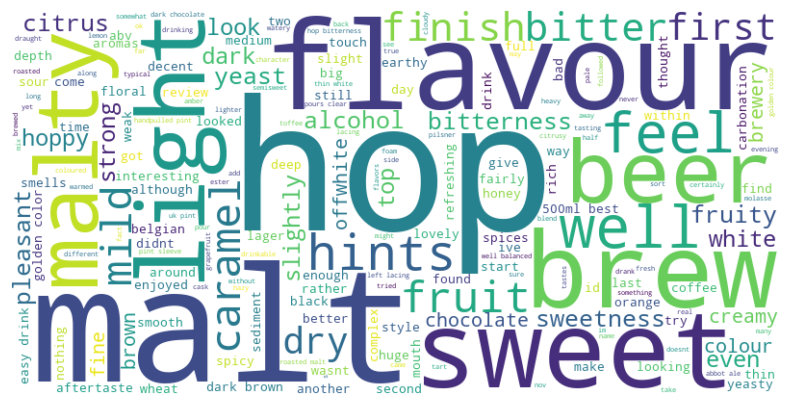

In [6]:
# Try plotting a wordcloud of the preprocessed text
plot_wordcloud(ba_data_clean['preprocessed text'])

**DATA LOADING AND DATA FRAME ORGANIZATION**

In [7]:
# Initialize a list to hold the beer data
#ici c'est pour toutes les charactéristiques des bières

beer_data = []

#this is used to use all of the data from the beeradvocate file, and

# Open the file and read line by line
with open(project_folder_fid+'matched_beer_data/ratings_with_text_ba.txt', 'r', encoding='utf-8') as file:
    beer_info = {}  # Temporary storage for each beer entry
    for line in file:
        # Strip whitespace and check if the line is not empty
        line = line.strip()
        if line:
            # Split on the first occurrence of ': ' and check for valid key-value pairs
            parts = line.split(': ', 1)  # Split into at most 2 parts
            if len(parts) == 2:  # Ensure we have both key and value
                key, value = parts
                beer_info[key] = value  # Store the value in the dictionary
            
                # When we reach the end of a beer entry (next empty line), save the entry
                if key == 'text':  # We assume 'text' is the last field for each beer entry
                    beer_data.append(beer_info)  # Append the entire beer_info dictionary to the list
                    beer_info = {}  # Reset the temporary storage for the next entry

# Create a DataFrame from the collected beer data
df_ba = pd.DataFrame(beer_data)

user_df_ba = pd.read_csv(project_folder_fid+'matched_beer_data/users.csv')
user_df_ba = user_df_ba.loc[:, user_df_ba.columns.str.startswith('ba')]
# Set the column names as the first row and remove the first row to be able to set it to the column names and merge correctly 
user_df_ba.columns = user_df_ba.iloc[0]
user_df_ba = user_df_ba[1:]

# Merge the user DataFrame with the existing DataFrame on the 'user_id' column
df_matched_data_ba = pd.merge(df_ba, user_df_ba, on='user_id', how='inner')

**DATA PREPROCESSING**

In [8]:
# 1. Remove NaN values from the data
df_matched_data_ba = df_matched_data_ba.dropna(subset=['text']) 

# 2. Apply the preprocess_text function to execute above defined text preprocessing steps
df_matched_data_ba['preprocessed text'] = df_matched_data_ba['text'].apply(preprocess_text)
display(df_matched_data_ba['preprocessed text'][1][1:100])

'ix pack georges deli case always oddball brewed rochester ny per label quot1060quot julian date nec'

**WORD CLOUD OF MOST COMMON WORDS**

Text(0.5, 1.0, 'Word Cloud of Beer Advocate Reviews')

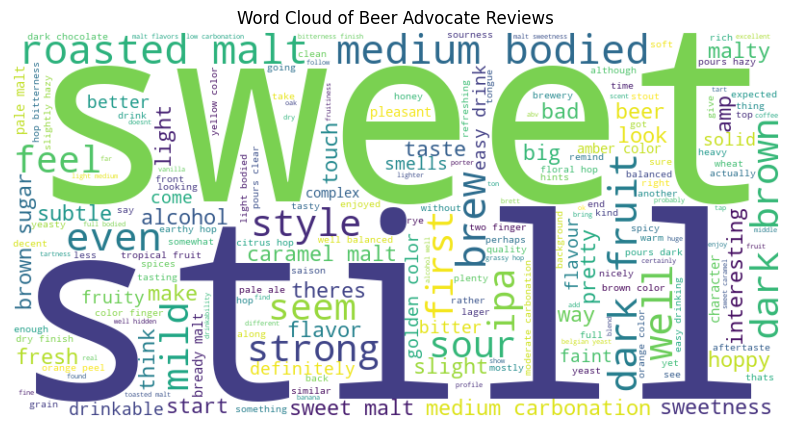

In [9]:
plot_wordcloud(df_matched_data_ba['preprocessed text'])
plt.title('Word Cloud of Beer Advocate Reviews')

Text(0.5, 1.0, 'Ratebeer Wordcloud')

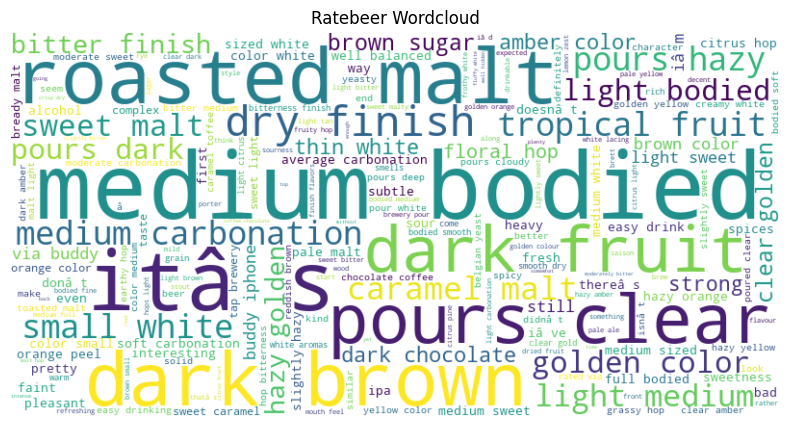

In [10]:
# Initialize a list to hold the beer data
#ici c'est pour toutes les charactéristiques des bières

beer_data = []

#this is used to use all of the data from the beeradvocate file, and

# Open the file and read line by line
with open(project_folder_fid+'matched_beer_data/ratings_with_text_rb.txt', 'r', encoding='utf-8') as file:
    beer_info = {}  # Temporary storage for each beer entry
    for line in file:
        # Strip whitespace and check if the line is not empty
        line = line.strip()
        if line:
            # Split on the first occurrence of ': ' and check for valid key-value pairs
            parts = line.split(': ', 1)  # Split into at most 2 parts
            if len(parts) == 2:  # Ensure we have both key and value
                key, value = parts
                beer_info[key] = value  # Store the value in the dictionary
            
                # When we reach the end of a beer entry (next empty line), save the entry
                if key == 'text':  # We assume 'text' is the last field for each beer entry
                    beer_data.append(beer_info)  # Append the entire beer_info dictionary to the list
                    beer_info = {}  # Reset the temporary storage for the next entry

# Create a DataFrame from the collected beer data
df_rb = pd.DataFrame(beer_data)

user_df_rb = pd.read_csv(project_folder_fid+'matched_beer_data/users.csv')
user_df_rb = user_df_rb.loc[:, user_df_rb.columns.str.startswith('rb')]
# Set the column names as the first row and remove the first row to be able to set it to the column names and merge correctly 
user_df_rb.columns = user_df_rb.iloc[0]
user_df_rb = user_df_rb[1:]

# Merge the user DataFrame with the existing DataFrame on the 'user_id' column
df_matched_data_rb = pd.merge(df_rb, user_df_rb, on='user_id', how='inner')

df_matched_data_rb = df_matched_data_rb.dropna(subset=['text']) 
df_matched_data_rb['preprocessed text'] = df_matched_data_rb['text'].apply(preprocess_text)

plot_wordcloud(df_matched_data_rb['preprocessed text'].tolist())
plt.title('Ratebeer Wordcloud')

Text(0.5, 1.0, 'Romania Reviews')

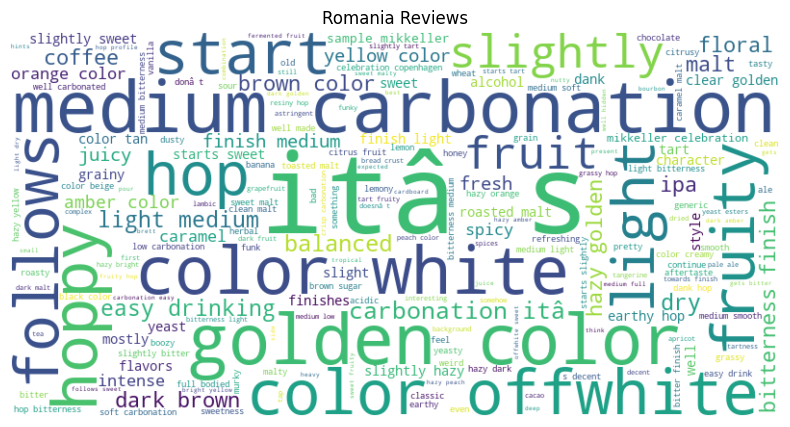

In [11]:
romania_reviews = df_matched_data_rb[df_matched_data_rb['location']=='Romania']
plot_wordcloud(romania_reviews['preprocessed text'].tolist())
plt.title('Romania Reviews')

Text(0.5, 1.0, 'Wordcloud All Reviews')

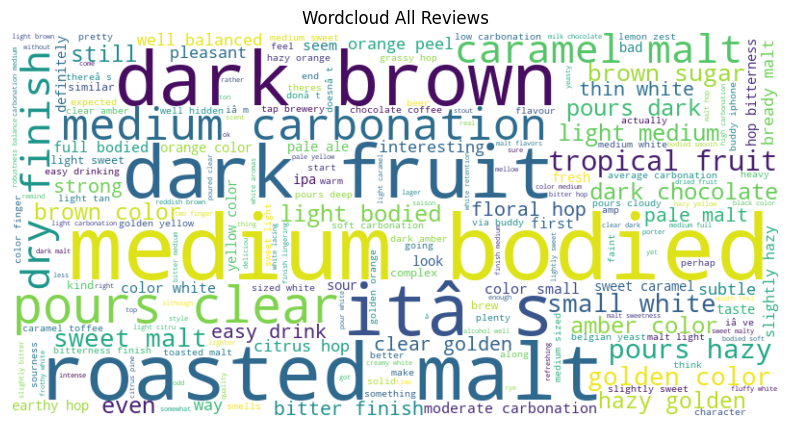

In [12]:
# Combine the RateBeer and BeerAdvocate reviews into a single DataFrame
df_combined_reviews = pd.concat([df_matched_data_rb, df_matched_data_ba], ignore_index=True)
plot_wordcloud(df_combined_reviews['preprocessed text'].tolist())
plt.title('Wordcloud All Reviews')

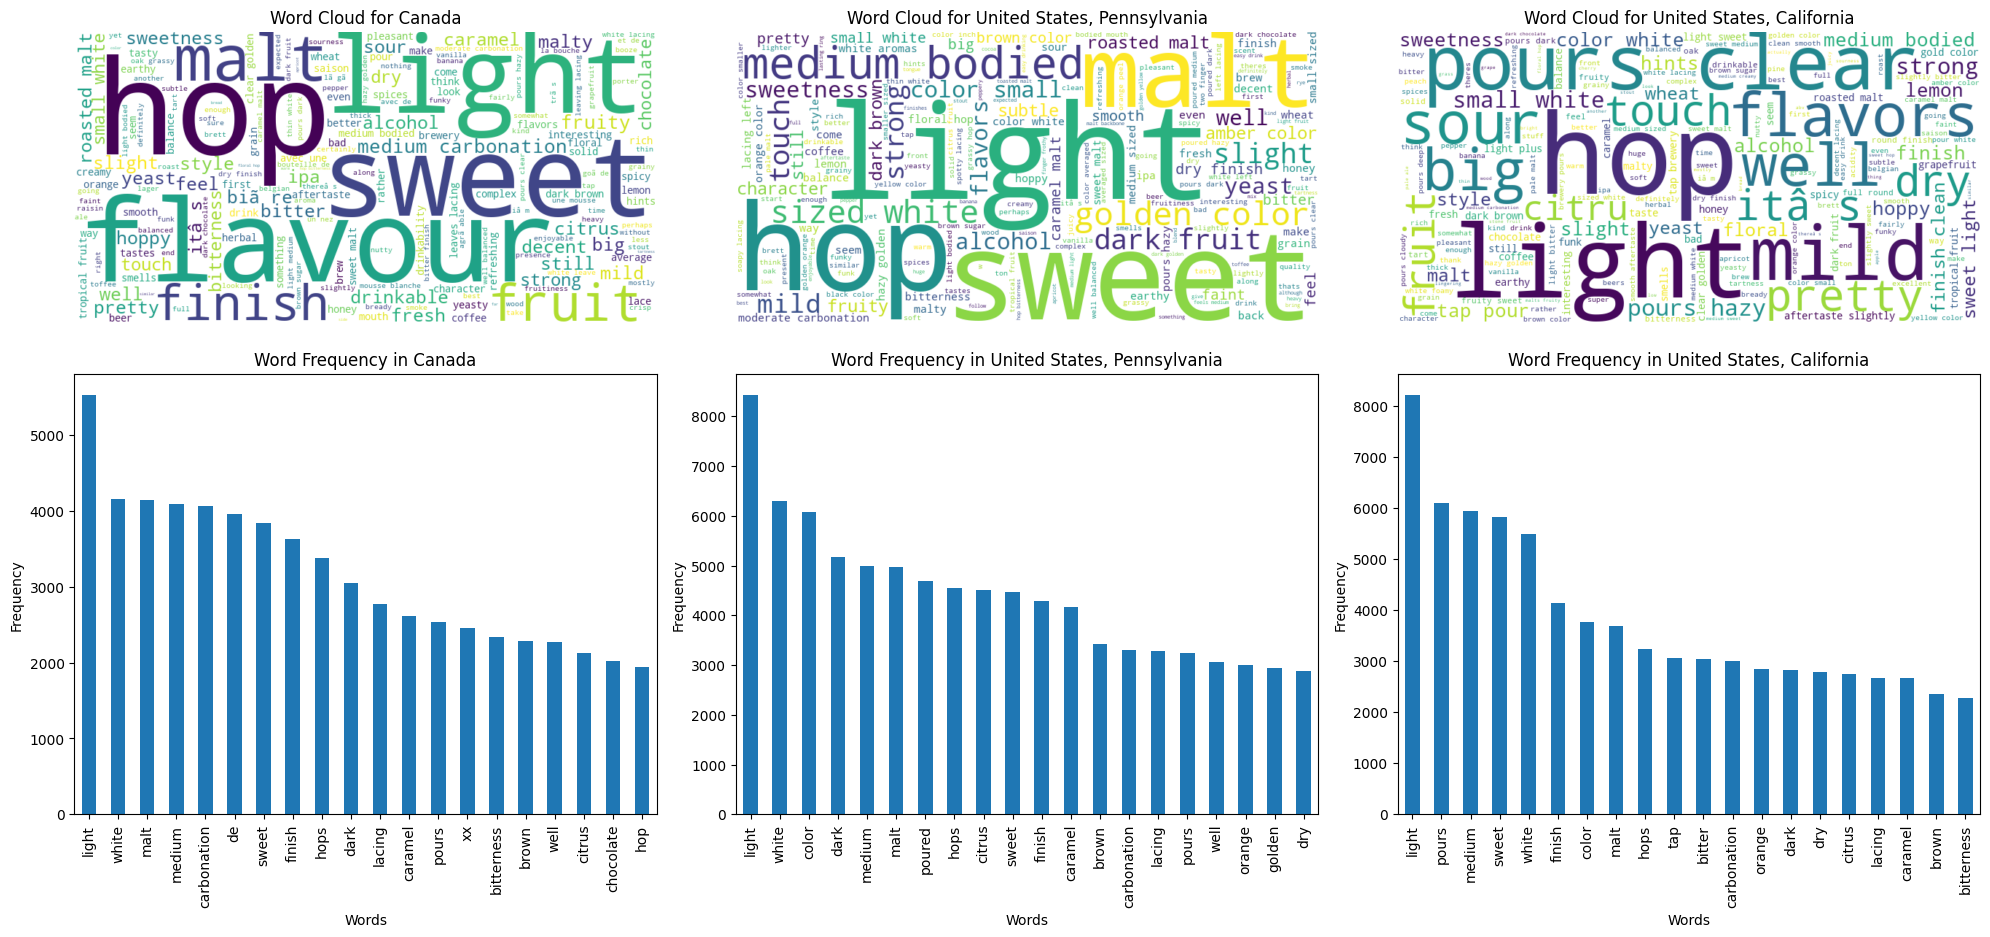

In [13]:
# Find the top 3 countries with the most users and plot the most words used in the reviews
top_countries = df_combined_reviews['location'].value_counts().head(3).index.tolist()

# Filter the data for the top 3 countries
top_countries_data = df_combined_reviews[df_combined_reviews['location'].isin(top_countries)]

# Plot word clouds for each of the top 3 countries
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for i, country in enumerate(top_countries):
    country_data = top_countries_data[top_countries_data['location'] == country]
    country_text = ' '.join(country_data['preprocessed text'])
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(country_text)
    
    # Plot word cloud
    axes[0, i].imshow(wordcloud, interpolation='bilinear')
    axes[0, i].set_title(f'Word Cloud for {country}')
    axes[0, i].axis('off')
    
    # Plot histogram
    words = country_text.split()
    word_freq = pd.Series(words).value_counts().head(20)
    word_freq.plot(kind='bar', ax=axes[1, i])
    axes[1, i].set_title(f'Word Frequency in {country}')
    axes[1, i].set_xlabel('Words')
    axes[1, i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

**SENTIMENT ANALYSIS**

In [14]:
# Create a much smaller dataset for testing
N = 100
df_small = df_combined_reviews.sample(n=N, random_state=42)

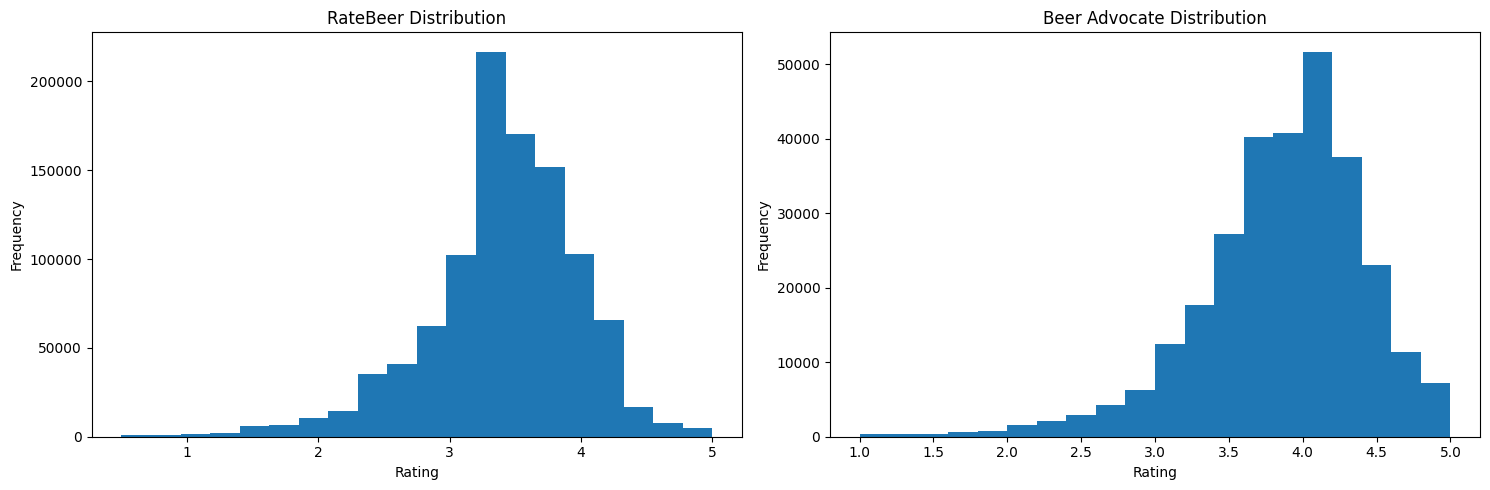

In [15]:
# Normalize Ratings: Convert ratings to a scale of 0-1
df_combined_reviews['rating'] = df_combined_reviews['rating'].astype(float)
df_combined_reviews['rating'] = (df_combined_reviews['rating'] - df_combined_reviews['rating'].min()) / (df_combined_reviews['rating'].max() - df_combined_reviews['rating'].min())

# Plot the distribution of ratings
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
df_rb['rating'].astype(float).plot(kind='hist', bins=20, ax=axes[0])
axes[0].set_title('RateBeer Distribution')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Frequency')

df_ba['rating'].astype(float).plot(kind='hist', bins=20, ax=axes[1])
axes[1].set_title('Beer Advocate Distribution')
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Based on the rating distribution we can set boundaries for loved, neutral, and disliked beer.

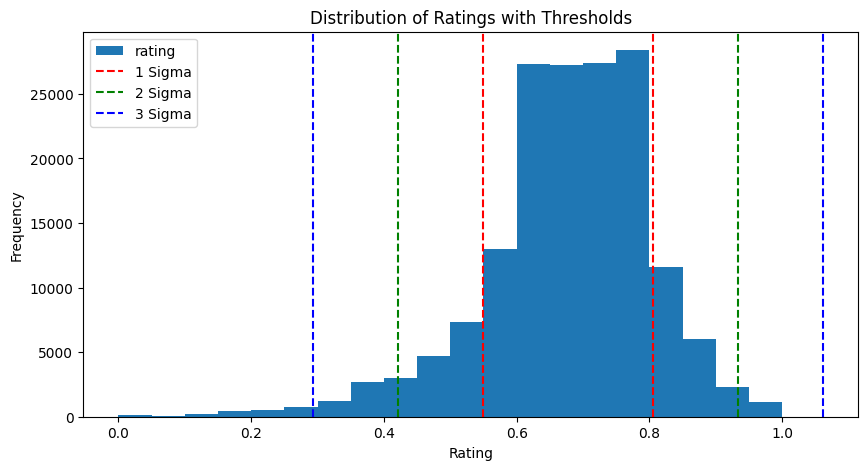

In [16]:
# Determine disliked, neutral, and liked thresholds based on the distribution of ratings

# Sort the ratings in ascending order
sorted_ratings = df_combined_reviews['rating'].sort_values()

# Calculate the 1 2 and 3 sigma thresholds
sd = sorted_ratings.std()
avg = sorted_ratings.mean()
one_sigma = avg + sd
two_sigma = avg + 2 * sd
three_sigma = avg + 3 * sd
minus_one_sigma = avg - sd
minus_two_sigma = avg - 2 * sd
minus_three_sigma = avg - 3 * sd

# Plot these thresholds on the distribution of ratings
fig, ax = plt.subplots(figsize=(10, 5))
df_combined_reviews['rating'].plot(kind='hist', bins=20, ax=ax)
ax.axvline(one_sigma, color='r', linestyle='--', label='1 Sigma')
ax.axvline(two_sigma, color='g', linestyle='--', label='2 Sigma')
ax.axvline(three_sigma, color='b', linestyle='--', label='3 Sigma')
ax.axvline(minus_one_sigma, color='r', linestyle='--')
ax.axvline(minus_two_sigma, color='g', linestyle='--')
ax.axvline(minus_three_sigma, color='b', linestyle='--')
ax.set_title('Distribution of Ratings with Thresholds')
ax.set_xlabel('Rating')
ax.set_ylabel('Frequency')
ax.legend()

plt.show()

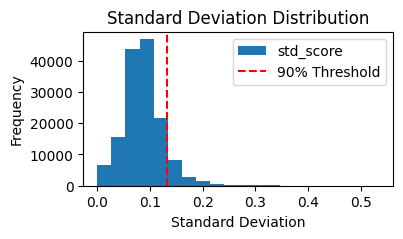

In [17]:
# Add an average score, standard deviation and number of ratings column to the data frame for each beer
df_combined_reviews['avg_score'] = df_combined_reviews.groupby('beer_id')['rating'].transform('mean')
df_combined_reviews['std_score'] = df_combined_reviews.groupby('beer_id')['rating'].transform('std')
df_combined_reviews['num_ratings'] = df_combined_reviews.groupby('beer_id')['rating'].transform('count')

# Top 90% of standard deviation scores
too_high_std = df_combined_reviews['std_score'].quantile(0.9)

# Plot the standard deviation distribution 
fig, ax = plt.subplots(figsize=(4, 2))
df_combined_reviews['std_score'].plot(kind='hist', bins=20, ax=ax)
ax.axvline(too_high_std, color='r', linestyle='--', label='90% Threshold')
ax.set_title('Standard Deviation Distribution')
ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Frequency')
ax.legend()

plt.show()



We can define any beer above a standard deviation of 0.15 to be a polrizing beer.

In [53]:
# Define each beer as liked, neutral, disliked and polarizing based on the thresholds
liked_threshold = one_sigma
disliked_threshold = minus_one_sigma
polarizing_threshold = too_high_std

"""
Categories the rating of a beer based on the average and standard deviation scores.

Parameters:
avg_score (float): The average score of the beer accross both websites.
std_score (float): The standard deviation score of the beer accross both websites.

Returns:
str: The category of the beer rating.
"""
def categorize_rating(avg_score, std_score, num_ratings, significance = 30):
    # Account for NaN and None values
    if pd.isnull(avg_score):
        return 'Unknown'
    if ~pd.isnull(std_score):
        if std_score > polarizing_threshold and num_ratings > significance: #TODO: This num_ratings threshold is arbitrary
            return 'Polarizing' 
        if avg_score >= liked_threshold:
            return 'Liked'
        elif avg_score <= disliked_threshold:
            return 'Disliked'
        elif disliked_threshold < avg_score < liked_threshold:
            return 'Neutral'
        else:
            return 'Unknown'
    else:
        if avg_score >= liked_threshold:
            return 'Liked'
        elif avg_score <= disliked_threshold:
            return 'Disliked'
        elif disliked_threshold < avg_score < liked_threshold:
            return 'Neutral'
        else:
            return 'Unknown'

    
"""
Basic helper function to categorize the rating of a beer:

"""
def apply_rating(row):
    return categorize_rating(row['avg_score'], row['std_score'], row['num_ratings'])

def apply_per_country_rating(row,sig):
    return categorize_rating(row['avg_score_per_country'], row['std_score_per_country'], row['num_ratings_per_country'], significance = sig)
    

"""
This function calculates the categorized ratings for each beer in the dataset 
internal to each country or US state.

Parameters:
df (pd.DataFrame): The input DataFrame containing the beer data with country information stored in the "location" column.

Returns:
pd.DataFrame: A DataFrame containing the categorized ratings for each beer in the dataset
internal to each country or US state.


"""
def calculate_ratings_by_country(df):
    column_name = 'location'

    # Ensure df is a DataFrame and column_name exists in df
    if not isinstance(df, pd.DataFrame):
        raise ValueError("The input df is not a pandas DataFrame.")
    if column_name not in df.columns:
        raise ValueError(f"The column '{column_name}' does not exist in the DataFrame.")

    # Get the unique countries of the location column
    countries = df[column_name].unique()

    # Initialize new columns in the DataFrame
    df['avg_score_per_country'] = None
    df['std_score_per_country'] = 0
    df['num_ratings_per_country'] = None
    df['rating_label_per_country'] = None

    for country in countries:
        # Filter the data for each country
        country_data = df[df[column_name] == country]

        # Calculate the average and standard deviation scores for each beer in the country
        country_data['avg_score_per_country'] = country_data.groupby('beer_id')['rating'].transform('mean')
        country_data['std_score_per_country'] = country_data.groupby('beer_id')['rating'].transform('std')
        country_data['num_ratings_per_country'] = country_data.groupby('beer_id')['rating'].transform('count')

        # Calculate the 90th percentile of the standard deviation scores for each country
        too_high_std = country_data['std_score_per_country'].quantile(0.9)

        # Categorize the rating of each beer in the country
        country_data['rating_label_per_country'] = country_data.apply(apply_per_country_rating, axis=1, args=(too_high_std,))

        # country_data['rating_label_per_country'] = country_data.apply(apply_per_country_rating, axis=1)

        # Update all the rows in the original data frame with the rows in the country data
        
        # List of columns to update
        update_columns = ['avg_score_per_country', 'std_score_per_country', 'num_ratings_per_country', 'rating_label_per_country']

        # Update the original DataFrame with the country data
        df.loc[country_data.index, update_columns] = country_data[update_columns]
    
    return df

In [54]:
# Categorize all of the beers based on their ratings
df_combined_reviews['rating_label'] = df_combined_reviews.apply(apply_rating, axis=1)

In [55]:
# Categorize the beers based on their ratings for every country
df_combined_reviews = calculate_ratings_by_country(df_combined_reviews)

**SHOW RESULTS OF RULES BASED SENTIMENT ANALYSIS**

In [65]:
# Define a function to plot the word cloud and word frequency graphs for a given country for each of the 4 labels of liked, neutral, disliked, and polarizing
def plot_country_wordclouds(df, country):
    country_data = df[df['location'] == country]
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    for i, label in enumerate(['Liked', 'Neutral', 'Disliked', 'Polarizing']):
        label_data = country_data[country_data['rating_label_per_country'] == label]
        label_text = ' '.join(label_data['preprocessed text'])
        
        # Generate word cloud
        wordcloud = WordCloud(width=1000, height=600, background_color='white', colormap='viridis').generate(label_text)
        
        # Plot word cloud
        axes[0, i].imshow(wordcloud, interpolation='bilinear')
        axes[0, i].set_title(f'Word Cloud for {label} Beers in {country}')
        axes[0, i].axis('off')
        
        # Plot histogram
        words = label_text.split()
        word_freq = pd.Series(words).value_counts().head(20)
        word_freq.plot(kind='bar', ax=axes[1, i])
        axes[1, i].set_title(f'Word Frequency for {label} Beers in {country}')
        axes[1, i].set_xlabel('Words')
        axes[1, i].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

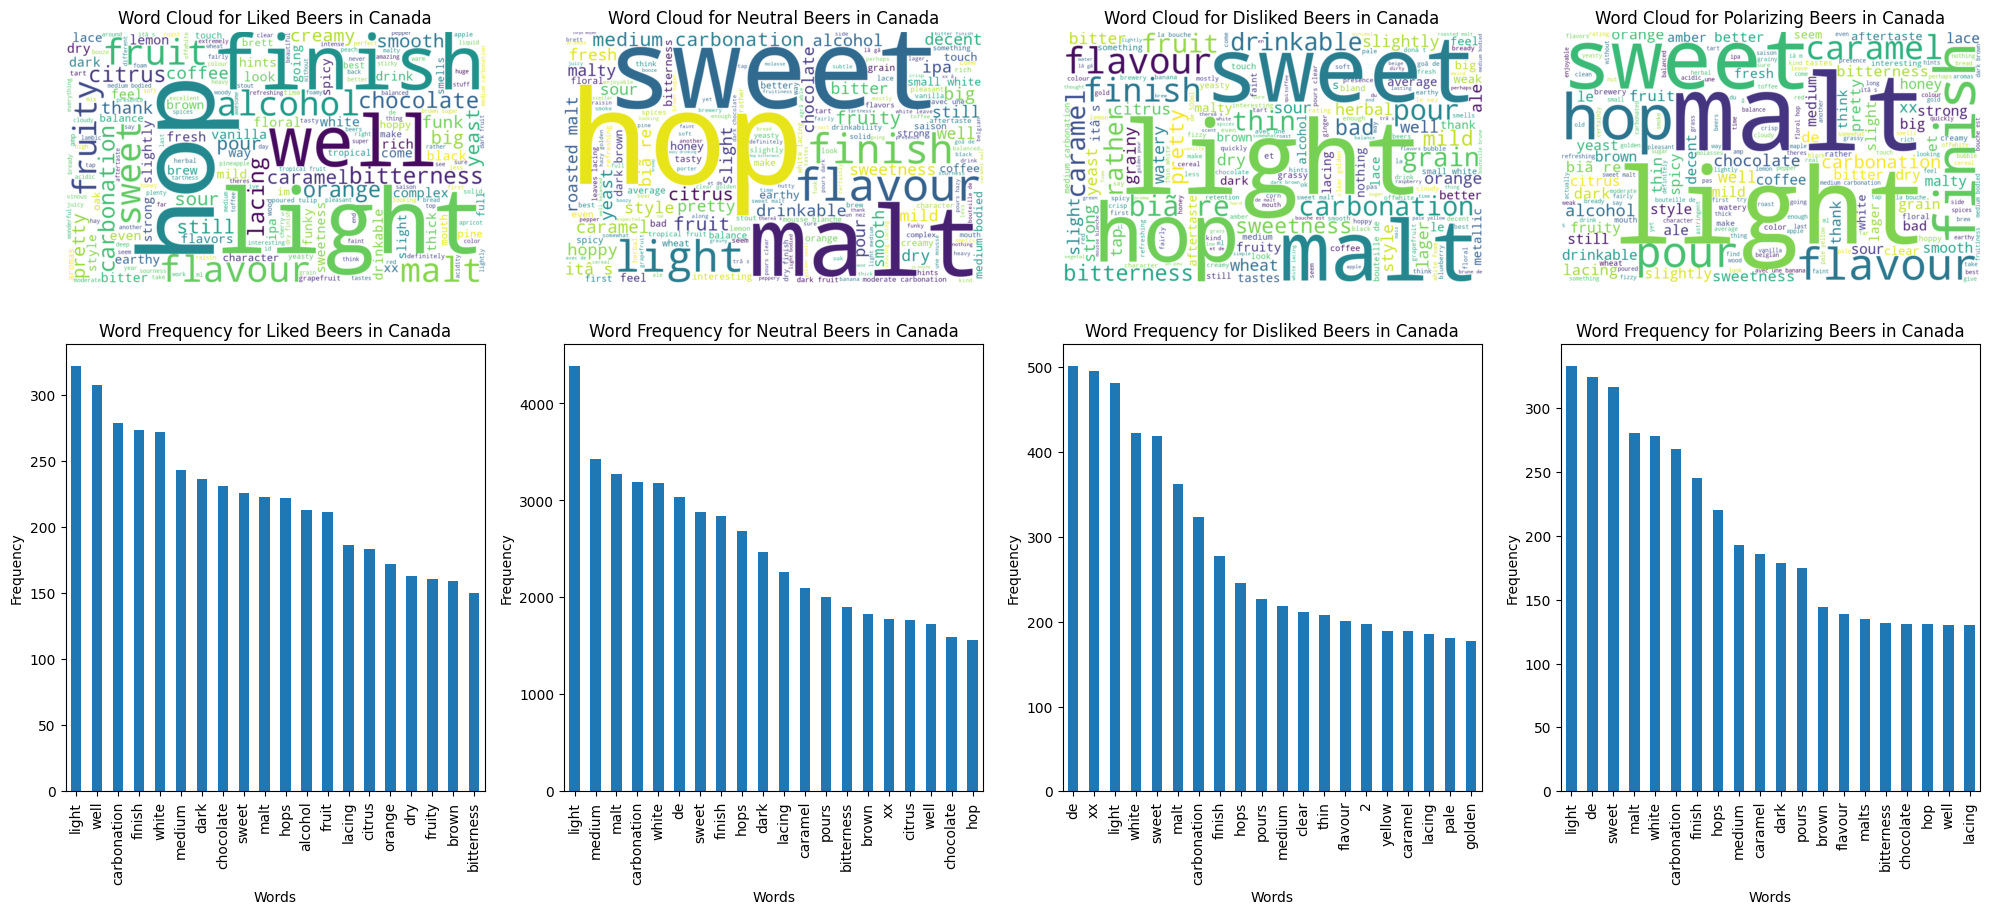

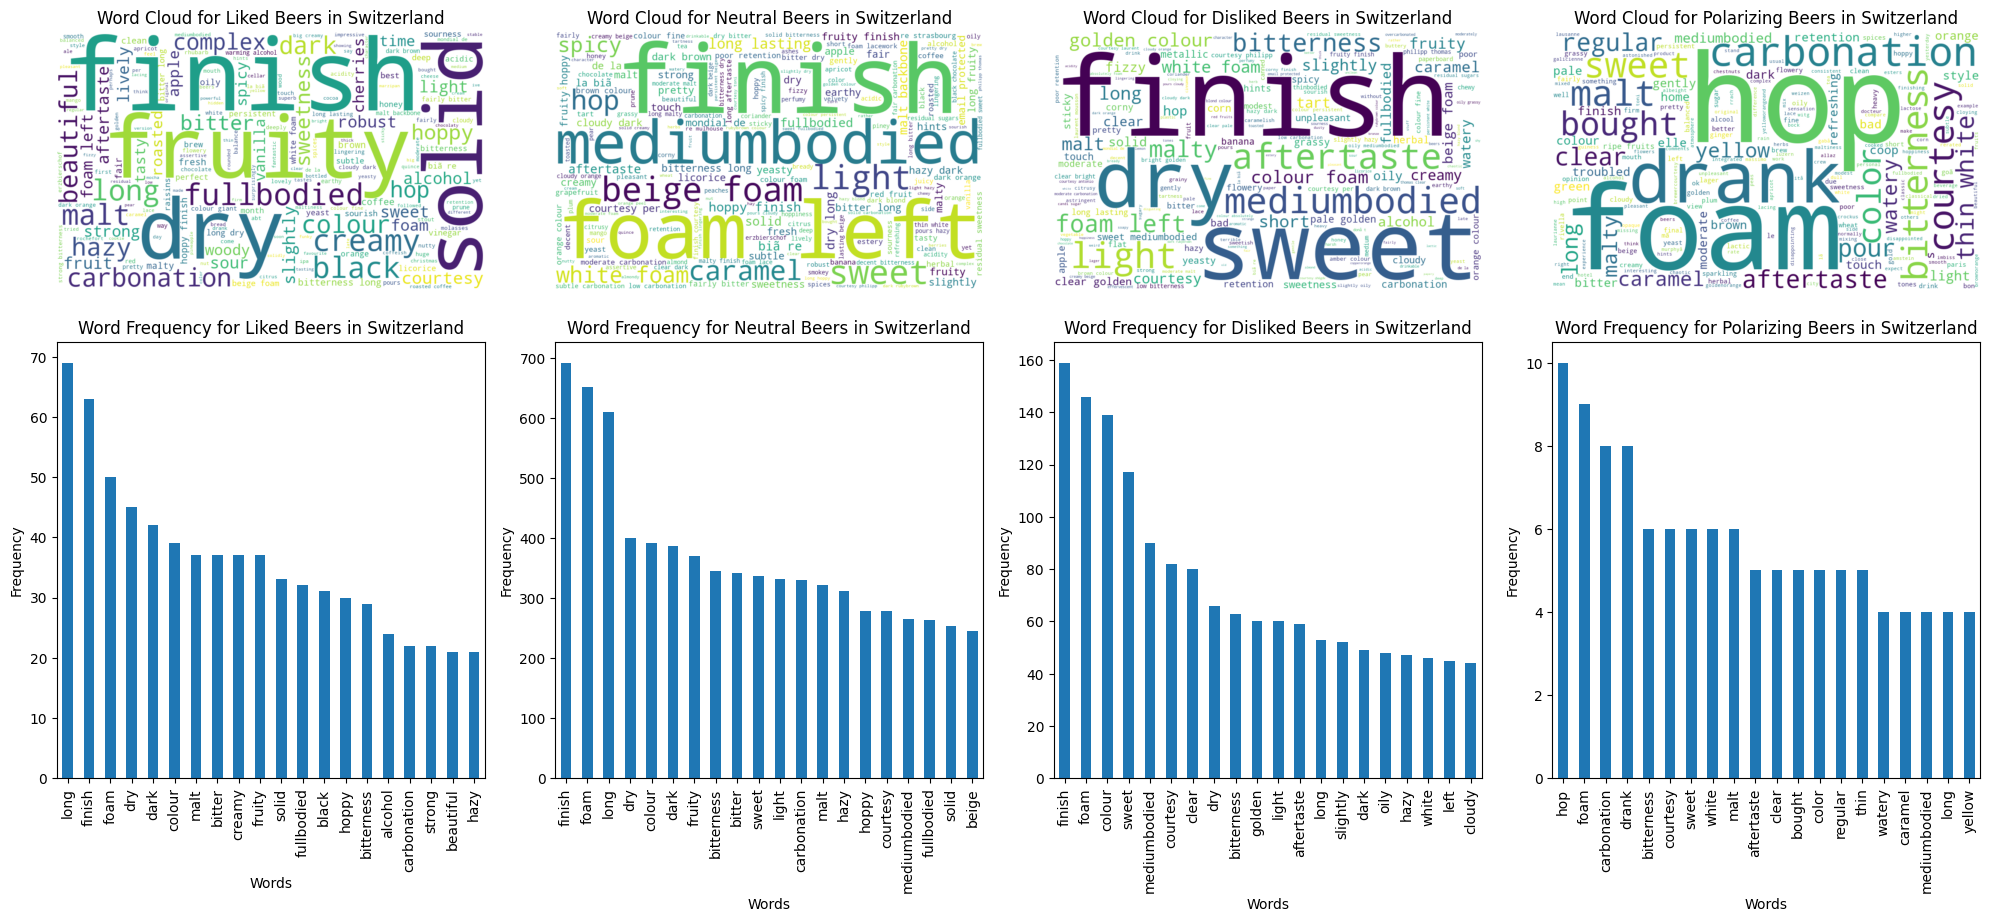

In [66]:
# Plot the word frequencies and word clouds for liked, neutral, and disliked beers in Swizerland and Canada
plot_country_wordclouds(df_combined_reviews, 'Canada')
plot_country_wordclouds(df_combined_reviews, 'Switzerland')
